In [1]:
import os
import pickle
import numpy as np
import scipy.io as sio
import copy
import jax.numpy as jnp
import mne
from src.Free_energy.meg_model import MEGModel
from src.Free_energy.meg_optimizer import MEGOptimizer
from src.Free_energy.utils import (
    compute_leadfield,
    temporal_reduction  

)
from utils.cortical.mesh_decimation import generate_and_save_surfaces
from utils.file_manip.vtk_processing import convert_triangles_to_pyvista


import importlib
import src.Free_energy.utils

importlib.reload(src.Free_energy.utils)  # Recharge le module

# Réimporter 


<module 'src.Free_energy.utils' from 'c:\\users\\wbou2\\desktop\\meg_to_surface_ml\\src\\Free_energy\\utils.py'>

In [2]:
# 2. Définition des chemins
PATHS = {
    'main': r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN",
    'data': r"C:\Users\wbou2\Desktop\meg_to_surface_ml\src\cortical_transformation\data",
    'fsaverage': r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\fsaverage",
    'subject': r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN\sub-CC710548",
    'meg_task': r"C:\Users\wbou2\Desktop\sub-CC710548\meg_task",
    "empty_room": r"C:\Users\wbou2\Desktop\sub-CC710548\emptyroom"
}

In [3]:
# 3. Chargement des harmoniques sphériques
Y_lh_full = np.load(os.path.join(PATHS['data'], "Y_lh.npz"))['Y']
Y_rh_full = np.load(os.path.join(PATHS['data'], "Y_rh.npz"))['Y']

In [50]:
# 4. Chargement des différences de coefficients
with open(os.path.join(PATHS['subject'], "coeffs_diff_lh.pkl"), 'rb') as f:
    coeffs_diff_lh = pickle.load(f)
with open(os.path.join(PATHS['subject'], "coeffs_diff_rh.pkl"), 'rb') as f:
    coeffs_diff_rh = pickle.load(f)


epsilon=1e-3

coeffs_diff_lh_eps = copy.deepcopy(coeffs_diff_lh)
coeffs_diff_rh_eps = copy.deepcopy(coeffs_diff_rh)
for l in [16,17]:
    for m in range(2*l+1):
        coeffs_diff_lh_eps["organized_coeffs"][l][m]+=np.array([epsilon+1j*epsilon, epsilon+1j*epsilon, epsilon+1j*epsilon])
        coeffs_diff_rh_eps["organized_coeffs"][l][m]+=np.array([epsilon+1j*epsilon, epsilon+1j*epsilon, epsilon+1j*epsilon])

In [55]:
# 5. Chargement des centres
lh_center = np.load(os.path.join(PATHS['subject'], "lh_center.npz"))['center']
rh_center = np.load(os.path.join(PATHS['subject'], "rh_center.npz"))['center']

# 6. Génération des surfaces
(lh_verts, lh_faces), (rh_verts, rh_faces) = generate_and_save_surfaces(
    main_folder=PATHS['main'],
    Y_lh_full=Y_lh_full,
    Y_rh_full=Y_rh_full,
    coeffs_diff_lh=coeffs_diff_lh_eps,
    coeffs_diff_rh=coeffs_diff_rh_eps,
    lh_center=lh_center,
    rh_center=rh_center,
    lmax=1,
    sigma=1e-4,
    fsaverage_path=PATHS['fsaverage'],
    merge=False 
)

In [56]:
# Définir le chemin vers le fichier des canaux MEG
meg_channel_path = os.path.join(PATHS['meg_task'], "channel_vectorview306_acc1.mat")

# Ensuite corriger les noms des variables pour qu'ils correspondent
leadfield, fwd, transform_matrix= compute_leadfield(
    meg_channel_path=meg_channel_path,
    lh_vertices=lh_verts,  
    lh_faces=lh_faces,
    rh_vertices=rh_verts,  
    rh_faces=rh_faces
)

Creating RawArray with float64 data, n_channels=306, n_times=1000
    Range : 0 ... 999 =      0.000 ...     0.999 secs
Ready.
Fitted sphere radius:         89.9 mm
Origin head coordinates:      0.8 -2.3 38.4 mm
Origin device coordinates:    0.8 -2.3 38.4 mm

Equiv. model fitting -> RV = 0.00349057 %%
mu1 = 0.944702    lambda1 = 0.137194
mu2 = 0.667435    lambda2 = 0.683781
mu3 = -0.26548    lambda3 = -0.0106058
Set up EEG sphere model with scalp radius    89.9 mm

Source space          : <SourceSpaces: [<surface (lh), n_vertices=7501, n_used=7501>, <surface (rh), n_vertices=7501, n_used=7501>] head coords, ~1.1 MiB>
MRI -> head transform : identity
Measurement data      : instance of Info
Sphere model      : origin at [0.   0.   0.04] mm
Standard field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 15002 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    1.000000 0.000000 0.000000       0.00 mm


In [57]:
import numpy as np
import pyvista as pv

def transform_points(points):
    points_homog = np.hstack([points, np.ones((points.shape[0], 1))])
    return (points_homog @ transform_matrix.T)[:, :3]

lh_vertices_t = transform_points(lh_verts)


# Supposons que vous récupérez lh_vertices_t depuis compute_leadfield
mesh = pv.PolyData(lh_vertices_t, convert_triangles_to_pyvista(lh_faces))

# Initialisation du plotter
p = pv.Plotter()

# Ajout du maillage cortical
p.add_mesh(mesh, show_edges=True, color='white')

# Extraction des positions des capteurs depuis fwd['info']
sensor_positions = np.array([ch['loc'][:3] for ch in fwd['info']['chs']])

# Ajout des capteurs sous forme de points rouges
p.add_points(sensor_positions, color='red', point_size=10)

# Affichage du repère et de la scène
p.show_axes()
p.show()

Widget(value='<iframe src="http://localhost:23890/index.html?ui=P_0x288f1c94fe0_6&reconnect=auto" class="pyvis…

In [3]:
# 8. Chargement des données MEG
meg_data = sio.loadmat(os.path.join(PATHS['meg_task'], "data_block001"))
noise_data=sio.loadmat(os.path.join(PATHS['empty_room'], "data_block001"))
data_cov = sio.loadmat(os.path.join(PATHS['meg_task'], "ndatacov_full.mat"))
noise_cov = sio.loadmat(os.path.join(PATHS['meg_task'], "noisecov_full.mat"))

In [34]:
Y_raw=meg_data["F"][:306,: 30000 ]
Y_noise = noise_data['F'][:306,:]

In [35]:
import numpy as np

def check_covariance_properties(Qe):
    # 1. Vérification de la symétrie
    is_symmetric = np.allclose(Qe, Qe.T)
    print("Symétrique:", is_symmetric)
    
    # 2. Vérification définie positive via valeurs propres
    eigenvals = np.linalg.eigvals(Qe)
    is_positive_definite = np.all(eigenvals > 0)
    print("Définie positive:", is_positive_definite)
    
    # 3. Vérification diagonale positive
    has_positive_diagonal = np.all(np.diag(Qe) > 0)
    print("Diagonale positive:", has_positive_diagonal)
    
    # 4. Condition number (stabilité numérique)
    cond = np.linalg.cond(Qe)
    print("Nombre de condition:", cond)
    
    # 5. Rang de la matrice
    rank = np.linalg.matrix_rank(Qe)
    print("Rang:", rank)
    print("Dimension:", Qe.shape)


def regularize_with_percentile_threshold(Qe, percentile=50):
    """
    Régularise une matrice de covariance en utilisant un seuil basé sur un percentile des valeurs propres.
    
    Parameters:
    -----------
    Qe : np.ndarray
        Matrice de covariance à régulariser
    percentile : float
        Percentile à utiliser comme seuil (entre 0 et 100, par défaut 50 = médiane)
    
    Returns:
    --------
    np.ndarray
        Matrice de covariance régularisée
    """
    # 1. Diagonalisation
    eigenvals, eigenvecs = np.linalg.eigh(Qe)
    
    # 2. Trouver la valeur seuil basée sur le percentile
    threshold = np.percentile(eigenvals, percentile)
    
    # 3. Seuiller les valeurs propres
    eigenvals_reg = np.maximum(eigenvals, threshold)
    
    # 4. Reconstruire la matrice
    Qe_reg = eigenvecs @ np.diag(eigenvals_reg) @ eigenvecs.T
    
    # 5. S'assurer de la symétrie (pour éviter les erreurs numériques)
    Qe_reg = (Qe_reg + Qe_reg.T) / 2
    
    return Qe_reg

# Pour vérifier le résultat :
Qe=noise_cov['NoiseCov'][:306, : 306]
Qe_reg = regularize_with_percentile_threshold(Qe, percentile=40)
check_covariance_properties(Qe_reg)

Symétrique: True
Définie positive: True
Diagonale positive: True
Nombre de condition: 26.48844466401453
Rang: 306
Dimension: (306, 306)


In [4]:
Y_raw = meg_data['F'][:306,30000: 50000]
Y_reduced, P_full, var_ratio, n_modes = temporal_reduction(
    Y_raw,
    freq_range=(1, 500),         # couvre quasiment tout le spectre
    variance_explained=1,        # conserve 100% de la variance
    bin_size=20000,     # un seul bin (optionnel)
    sfreq=1000
)


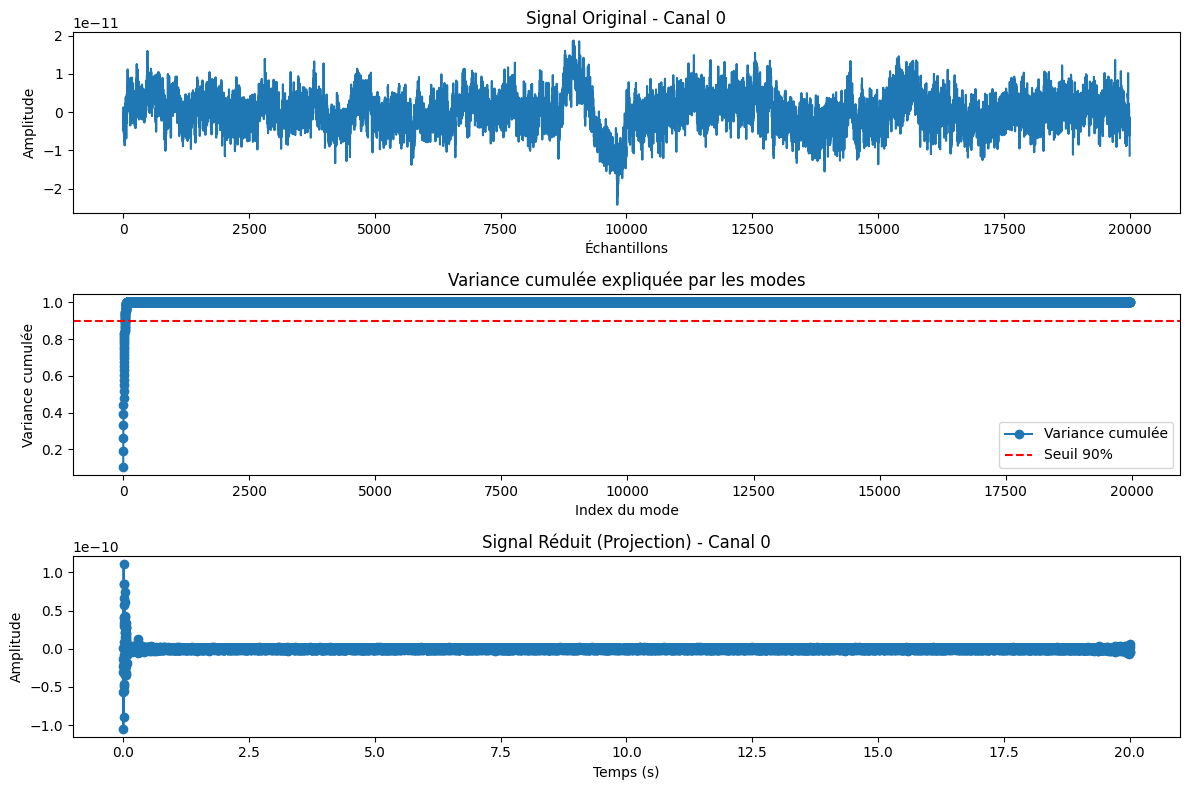

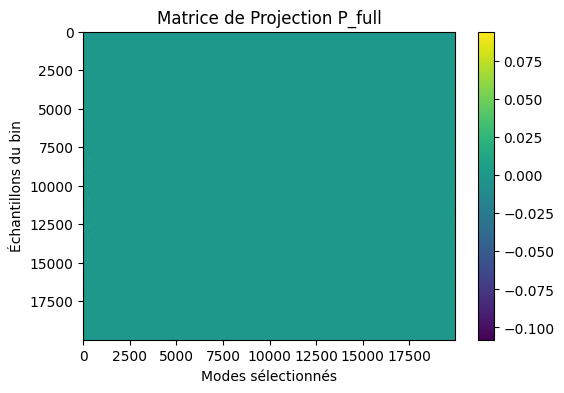

Nombre de modes sélectionnés : 19961
Forme du signal original (Y_raw) : (306, 20000)
Forme du signal réduit (Y_reduced) : (306, 19960)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# On suppose que Y_raw, Y_reduced, P_full, var_ratio et n_modes sont déjà définis, par exemple :
# Y_raw = meg_data['F'][:306,30000:150000]
# Y_reduced, P_full, var_ratio, n_modes = temporal_reduction(Y_raw, freq_range=(8, 40), 
#                                                            variance_explained=0.9, 
#                                                            bin_size=6000, sfreq=1000)

# 1. Visualisation du signal original pour le canal 0
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(Y_raw[0, :])
plt.title("Signal Original - Canal 0")
plt.xlabel("Échantillons")
plt.ylabel("Amplitude")

# 2. Courbe de variance cumulée expliquée
plt.subplot(3, 1, 2)
plt.plot(var_ratio, 'o-', label="Variance cumulée")
plt.axhline(y=0.9, color='r', linestyle='--', label="Seuil 90%")
plt.title("Variance cumulée expliquée par les modes")
plt.xlabel("Index du mode")
plt.ylabel("Variance cumulée")
plt.legend()

# 3. Visualisation du signal réduit pour le canal 0
plt.subplot(3, 1, 3)
# Y_reduced a une dimension temporelle de n_bins * n_modes.
# On crée un axe temporel réduit en secondes (en supposant sfreq=1000 Hz et bin_size=6000).
n_samples_reduced = Y_reduced.shape[1]
t_reduced = np.linspace(0, Y_raw.shape[1] / 1000, n_samples_reduced)
plt.plot(t_reduced, Y_reduced[0, :], 'o-')
plt.title("Signal Réduit (Projection) - Canal 0")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

# Optionnel : Visualisation de la matrice de projection (P_full)
plt.figure(figsize=(6, 4))
plt.imshow(P_full, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Matrice de Projection P_full")
plt.xlabel("Modes sélectionnés")
plt.ylabel("Échantillons du bin")
plt.show()

# Affichage d'informations sur la réduction
print(f"Nombre de modes sélectionnés : {n_modes}")
print(f"Forme du signal original (Y_raw) : {Y_raw.shape}")
print(f"Forme du signal réduit (Y_reduced) : {Y_reduced.shape}")


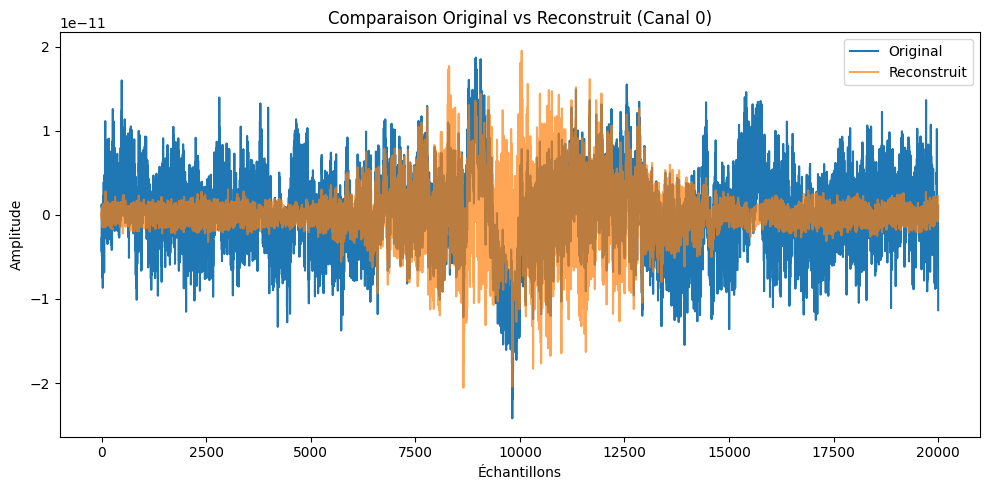

Erreur moyenne de reconstruction : 2.17e-12


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Supposons que tu disposes déjà de :
# - Y_raw : le signal original (n_channels, n_times)
# - Y_reduced : le signal projeté (n_channels, n_bins * n_modes)
# - P_full : la matrice de projection (bin_size, n_modes)
# - bin_size, n_modes, sfreq, etc.
# - la même fenêtre Hanning w que celle utilisée dans la fonction temporal_reduction.
bin_size=20000

# Ex. si tu n'as plus la fenêtre, il faut la redéfinir à l'identique :
w = signal.windows.hann(bin_size, sym=False)

n_channels, n_times = Y_raw.shape
n_bins = n_times // bin_size

# Liste pour stocker les bins reconstruits
Y_reconstructed_list = []

for i in range(n_bins):
    # Portion de Y_reduced associée au bin i : dimensions (n_channels, n_modes)
    Y_bin_reduced = Y_reduced[:, i*n_modes:(i+1)*n_modes]
    
    # Reprojection dans l'espace "fenêtré"
    # (bin_size, n_modes) -> (n_modes, ) => multiplication
    # Donc (n_channels, n_modes) @ (n_modes, bin_size) => (n_channels, bin_size)
    Y_bin_windowed_rec = Y_bin_reduced @ P_full.T
    
    # "Défenêtrer" en divisant par w (attention aux zéros sur les bords)
    w_nonzero = np.where(w == 0, 1e-10, w)  # éviter la division par zéro
    Y_bin_rec = Y_bin_windowed_rec / w_nonzero
    
    Y_reconstructed_list.append(Y_bin_rec)

# Concaténer les bins reconstruits sur l'axe temporel
Y_reconstructed = np.concatenate(Y_reconstructed_list, axis=1)

# Visualisation : comparaison entre original et reconstruit (canal 0)
plt.figure(figsize=(10, 5))
plt.plot(Y_raw[0, :], label="Original")
plt.plot(Y_reconstructed[0, :], label="Reconstruit", alpha=0.7)
plt.title("Comparaison Original vs Reconstruit (Canal 0)")
plt.xlabel("Échantillons")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# Optionnel : afficher l'erreur moyenne
erreur_moy = np.mean(np.abs(Y_reconstructed - Y_raw))
print(f"Erreur moyenne de reconstruction : {erreur_moy:.2e}")


In [58]:
import jax.numpy as jnp
import jax
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoNormal
import numpyro.optim as optim
from numpyro.infer.initialization import init_to_value



def process_data(Y_reduced, leadfield, Qe, n_components=30):
    """
    Prépare les données en appliquant un prétraitement identique à MNE :
      - Normalisation du leadfield (chaque colonne est ramenée à une norme unitaire).
      - Recalibrage de la matrice Qe pour que la variance par canal soit environ 1.
      - Whitening via la factorisation de Qe.
      - Réduction dimensionnelle par SVD.
    
    Retourne un dictionnaire contenant les matrices préparées pour la reconstruction.
    """
    # Convertir en jnp.array (float32)
    Y_reduced = jnp.asarray(Y_reduced, dtype=jnp.float32)
    leadfield = jnp.asarray(leadfield, dtype=jnp.float32)
    Qe = jnp.asarray(Qe, dtype=jnp.float32)

    # --- Normalisation du leadfield ---
    # Chaque colonne de leadfield est divisée par sa norme
    L_norms = jnp.linalg.norm(leadfield, axis=0, keepdims=True)
    leadfield = leadfield / L_norms 

    # --- Recalibrage de Qe ---
    # On souhaite que la variance par canal soit d'environ 1
    diag_mean = jnp.mean(jnp.real(jnp.diag(Qe)))
    if diag_mean > 0:
        Qe = Qe / diag_mean
    else:
        raise ValueError("La moyenne de la diagonale de Qe est négative ou nulle.")

    # --- Whitening du bruit via Cholesky ---
    # Ici, on réalise le whitening en résolvant R * X = Data avec R = chol(Qe)
    R = jnp.linalg.cholesky(Qe)
    Y_white = jnp.linalg.solve(R, Y_reduced)
    L_white = jnp.linalg.solve(R, leadfield)
    
    # --- Réduction dimensionnelle via SVD ---
    U, s, Vh = jnp.linalg.svd(L_white, full_matrices=False)
    n_components = min(n_components, len(s))
    U_k = U[:, :n_components]
    
    Y_reduced_spatial = U_k.T @ Y_white           
    L_reduced_spatial = U_k.T @ L_white
    Qe_reduced = jnp.eye(n_components)
    Y_obs = Y_reduced_spatial.T  # observations dans l'espace réduit
    
    n_samples = Y_reduced.shape[1]
    M = L_reduced_spatial.T @ L_reduced_spatial / n_samples
    # Ajout d'une régularisation explicite
    M_reg = M
    M_reg =  regularize_with_percentile_threshold(M_reg, percentile=60)
    Qa = jnp.linalg.inv(M_reg)
    
    cov_term = L_reduced_spatial @ Qa @ L_reduced_spatial.T
    cov_term =  regularize_with_percentile_threshold(cov_term, percentile=60)
    
    return {
        'Y_reduced_spatial': Y_reduced_spatial,
        'L_reduced_spatial': L_reduced_spatial,
        'Qa': Qa,
        'Y_obs': Y_obs,
        'Qe_reduced': Qe_reduced,
        'cov_term': cov_term,
        'U_k': U_k,
        'R': R,
        'leadfield': leadfield  # sauvegarde de la matrice originale normalisée
    }

def model_qe(Y_obs, cov_term, Qe_reduced, Nt, n_components):
    """
    Modèle probabiliste utilisant la covariance pré-calculée et régularisée.
    """
    log_gamma = numpyro.sample("log_gamma", dist.Normal(-3.0, 20.0))
    gamma = jnp.exp(log_gamma)
    Sigma = gamma * Qe_reduced + cov_term
    mean = jnp.zeros(n_components)
    with numpyro.plate("obs", Nt):
        numpyro.sample("Y", dist.MultivariateNormal(mean, covariance_matrix=Sigma), obs=Y_obs)

def compute_source_estimate(data_dict, gamma):
    """
    Calcule l'estimation des sources J à partir des données prétraitées et de gamma.
    Un jitter est ajouté lors de l'inversion pour la stabilité numérique.
    """
    L = data_dict['L_reduced_spatial']
    Y = data_dict['Y_reduced_spatial']
    Qa = data_dict['Qa']
    Qe = gamma * data_dict['Qe_reduced']
    
    inv_term = jnp.linalg.inv(L @ Qa @ L.T + Qe )
    K = Qa @ L.T @ inv_term
    
    # Estimation des sources
    J = K @ Y
    return J, K

# def compute_metrics(Y_reduced, data_dict, J, laplacian=None):
#     """
#     Calcule diverses métriques pour évaluer la qualité de la reconstruction.
#     La reconstruction est réalisée en revenant dans l'espace capteur via U_k et R.
#     """
#     U_k = data_dict['U_k']
#     R = data_dict['R']
#     L_reduced_spatial = data_dict['L_reduced_spatial']
    
#     # Reconstruction dans l'espace whitened puis passage en espace capteur
#     Y_white_pred = U_k @ (L_reduced_spatial @ J)
#     Y_pred = R @ Y_white_pred
    
#     metrics = {}
    
#     # Erreur relative de reconstruction
#     err_num = jnp.linalg.norm(Y_reduced - Y_pred, 'fro')**2
#     err_den = jnp.linalg.norm(Y_reduced, 'fro')**2
#     metrics['reconstruction_error'] = jnp.real(err_num / err_den)
    
#     # Complexité spatiale
#     if laplacian is not None:
#         spatial_smoothness = jnp.linalg.norm(laplacian @ J, 'fro')**2
#     else:
#         spatial_smoothness = jnp.linalg.norm(jnp.diff(J, axis=0), 'fro')**2
#     metrics['spatial_smoothness'] = jnp.real(spatial_smoothness / jnp.linalg.norm(J, 'fro')**2)
    
#     # Complexité L2
#     n_sources = J.shape[0]
#     metrics['l2_complexity'] = jnp.real(jnp.linalg.norm(J, 'fro')**2 / n_sources)
    
#     # Complexité L1
#     metrics['l1_complexity'] = jnp.real(jnp.sum(jnp.abs(J))) / n_sources
    
#     return metrics

def run_inference_qe(Y_reduced, leadfield, Qe, n_components=20, num_steps=200, learning_rate=0.1, L_FULL=None):
    """
    Version avec Adam et learning rate schedule
    """
    print("Starting inference...")
    
    data_dict = process_data(
        Y_reduced, leadfield, Qe,
        n_components=n_components
    )
    
    Nt = data_dict['Y_obs'].shape[0]
    
    # On garde l'AutoNormal pour avoir un vrai postérieur approximatif
    log_gamma_init = -1.0
    init_values = {"log_gamma": log_gamma_init}
    guide = AutoNormal(model_qe, init_loc_fn=init_to_value(values=init_values))
    
    # Utilisation d'Adam avec learning rate schedule
    scheduler = lambda step: max(learning_rate * (0.95 ** (step // 20)), 1e-4)
    optimizer = optim.Adam(scheduler)
    
    svi = SVI(model_qe, guide, optimizer, loss=Trace_ELBO())
    
    rng_key = jax.random.PRNGKey(0)
    svi_state = svi.init(rng_key, data_dict['Y_obs'], data_dict['cov_term'], 
                         data_dict['Qe_reduced'], Nt, n_components)
    
    losses = []
    params_history = []
    
    for step in range(num_steps):
        svi_state, loss = svi.update(
            svi_state, data_dict['Y_obs'], data_dict['cov_term'],
            data_dict['Qe_reduced'], Nt, n_components
        )
        losses.append(-loss / Nt)  # ELBO négatif normalisé par le nombre d'observations
        
        curr_params = svi.get_params(svi_state)
        params_history.append({k: v.copy() for k, v in curr_params.items()})
        
        if (step + 1) % 20 == 0:
            curr_lr = scheduler(step)
            print(f'Step {step+1}: ELBO = {-loss/Nt:.4f}, LR = {curr_lr:.6f}')
            curr_values = guide.median(curr_params)
            print(f"  log_gamma: {curr_values['log_gamma']:.4f}")
            print(f"  gamma: {jnp.exp(curr_values['log_gamma']):.4e}")
    
    final_params = svi.get_params(svi_state)
    
    # Échantillonnage du postérieur avec AutoNormal
    num_samples = 1000
    rng_key = jax.random.PRNGKey(0)
    guide_samples = guide.sample_posterior(rng_key, final_params, sample_shape=(num_samples,))
    gamma_samples = jnp.exp(guide_samples['log_gamma'])
    
    mean_gamma = jnp.mean(gamma_samples)
    J, K = compute_source_estimate(data_dict, mean_gamma)
    
    return {
        "params": final_params,
        "elbo": losses[-1],  # Déjà normalisé par Nt
        "gamma": {
            "mean": mean_gamma,
            "ci": jnp.percentile(gamma_samples, jnp.array([2.5, 97.5])),
            "samples": gamma_samples
        },
        "losses": losses,
        "params_history": params_history,
        "J": J,
    }


In [59]:
results = run_inference_qe(
    Y_raw, 
    leadfield, 
    Qe_reg,
    n_components=306,
    num_steps=2000,
    learning_rate=0.2,
)

Starting inference...
Step 20: ELBO = -2466.3157, LR = 0.200000
  log_gamma: -3.9393
  gamma: 1.9461e-02
Step 40: ELBO = -2466.3157, LR = 0.190000
  log_gamma: -5.2430
  gamma: 5.2846e-03
Step 60: ELBO = -2466.3157, LR = 0.180500
  log_gamma: -5.7572
  gamma: 3.1600e-03
Step 80: ELBO = -2466.3157, LR = 0.171475
  log_gamma: -6.0956
  gamma: 2.2528e-03
Step 100: ELBO = -2466.3157, LR = 0.162901
  log_gamma: -6.6559
  gamma: 1.2864e-03
Step 120: ELBO = -2466.3157, LR = 0.154756
  log_gamma: -6.8467
  gamma: 1.0629e-03
Step 140: ELBO = -2466.3157, LR = 0.147018
  log_gamma: -7.3549
  gamma: 6.3945e-04
Step 160: ELBO = -2466.3157, LR = 0.139667
  log_gamma: -7.9753
  gamma: 3.4385e-04
Step 180: ELBO = -2466.3157, LR = 0.132684
  log_gamma: -8.0919
  gamma: 3.0601e-04
Step 200: ELBO = -2466.3157, LR = 0.126050
  log_gamma: -8.1392
  gamma: 2.9188e-04
Step 220: ELBO = -2466.3157, LR = 0.119747
  log_gamma: -8.2828
  gamma: 2.5282e-04
Step 240: ELBO = -2466.3157, LR = 0.113760
  log_gamma: -8

KeyboardInterrupt: 